## Chlorphyll-a Next frame prediction based on CNN-LSTM



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%pip install cartopy
%pip install tensorflow
%pip install keras

In [3]:
import os
import numpy as np
import xarray as xr
from datetime import datetime, timedelta
import pickle
import time
import random
from tqdm import tqdm
import numpy as np
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Reshape, Input
from datetime import datetime, timedelta
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, TimeDistributed, Conv2D, ConvLSTM2D
import cartopy as crs
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cv2
from matplotlib.patches import Polygon

### Globals

In [4]:
# Caution: Not a good idea to use globals in programming. But ....

# Contains listing of all wavelength in nm
G_Wavelengths = [0] * 1

# Max reflectance of each wavelength
GRmax = [0] * 1

# Reject images that have less than this many valid pixels.
# Meaning if there are too many NaNs, the image can skew training
G_validPixelsInImage = 5000

# Max value of chla to clamp to; Clamps outliers
G_maxChla = 600

# Global to reuse existing model from checkpoint
include_training = True

# Boolean to choose between SSIM and MSE loss function
G_use_ssim_loss = False

## Utility Functions

Files downloaded from earthaccess as granules. These are post-processed to aggregate 7 day moving average into a numpy file marked by a single date. It contains reading for all 22 channels for all lat, lon in one numpy array. The lat, lon information is in a separate metadate file.
Note that though there are 22 channels, only 11 of them carry valid values. The rest of the channels are NaNs, except the last one channel-id 21 which carries the chla readings

In [5]:
def get_numpy_data_from_file(data_path=None, metadata_path=None):
    data = np.load(data_path)
    with open(metadata_path, "rb") as f:
        metadata = pickle.load(f)

    # Bad coding habit, but using this for now
    global G_Wavelengths
    G_Wavelengths = metadata["wavelengths"][0:11]
    lat = metadata['lat']
    lon = metadata['lon']

    from datetime import datetime
    datestr = data_path.split('_')[-1]
    datestr = datestr.split('.')[0]
    start_date = datetime.strptime(datestr, "%Y-%m-%d")
    return (lat, lon, start_date, data)


### Plotting all wavelengths for a given day

This is meant to read the raw npy file and metadata and plot. The last channel (id: 21) is the 'chla' wavelength. It is not in the same scale as the other wavelengths. So, we'll exclude chla channel in this plot

In [6]:
def plot_day_spectrum_by_file(day_index, data_path="../Images/composite_data_S3_2019-01-07.npy", \
                      metadata_path="../Images/composite_metadata_S3_2019-01-07.pkl"):
    """
    Plots the mean spectrum for a given day index.

    Parameters:
        day_index (int): The index of the day (0 = first day in composite array).
        data_path (str): Path to the saved numpy array.
        metadata_path (str): Path to the saved metadata (pickle file).
    """
    # Load data and metadata
    data = np.load(data_path)
    print("data.shape:", data.shape)
    with open(metadata_path, "rb") as f:
        metadata = pickle.load(f)

    #CHLA
    global G_Wavelengths
    G_Wavelengths = metadata["wavelengths"][0:11]
    print("G_Wavelengths:", G_Wavelengths)
    wavelengths = G_Wavelengths

    # Sanity check for day index
    if day_index < 0 or day_index >= data.shape[0]:
        print(f"Day index {day_index} is out of range. Data has {data.shape[0]} days.")
        return

    # Get the day's data
    day_data = data[day_index]  # shape (h, w, c)

    #CHLA
    day_data = day_data[:,:,0:11]

    # Average over h, w (ignoring NaNs)
    mean_spectrum = np.nanmean(day_data, axis=(0, 1))  # shape (c,)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, mean_spectrum, marker='o', linestyle='-')
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Mean Intensity (sr$^{-1}$ m$^{-2}$ nm$^{-1}$)")
    plt.title(f"Mean Spectrum for Day Index {day_index}")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

### Plotting all wavelengths for an image

The input is an image in the shape (93, 164, X). However, this function will just pick the first 11 channels. Plot the mean avergaes of the 11 different wavelengths for the entire lake image.

In [7]:
def plot_image_spectrum(image1, image2=None):

    """
    Plots the mean spectrum of image (93, 163, 14)

    Parameters:
        image (numpy array): The image (93, 163, 14)
    """

    global G_Wavelengths
    wavelengths = G_Wavelengths

    # Average over h, w (ignoring NaNs)
    mean_spectrum1 = np.nanmean(image1[:, :, :11], axis=(0, 1))  # shape (11,)
    if image2 is not None:
      mean_spectrum2 = np.nanmean(image2[:, :, :11], axis=(0, 1))  # shape (11,)

    print(mean_spectrum1.shape, wavelengths.shape)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, mean_spectrum1, marker='o', linestyle='-')
    if image2 is not None:
      plt.plot(wavelengths, mean_spectrum2, marker='o', linestyle='-.')
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Mean Intensity (sr$^{-1}$ m$^{-2}$ nm$^{-1}$)")
    plt.title(f"Mean Spectrum Image")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(['True', 'Pred'])
    plt.tight_layout()
    plt.show()

### Chlrophyll-a segmentation plot
Since this reading has a large range from 0.1 to 1000, we we'll have to plot using log of the values. Chla readings are in band 21.


In [8]:
def plot_chla_image(data_path="../Images/composite_data_S3_2019-01-07.npy",
                    metadata_path="../Images/composite_metadata_S3_2019-01-07.pkl",
                    band_index=21, min_thresh=2.5, max_thresh=7.0):

    lat, lon, start_date, data = get_numpy_data_from_file(data_path, metadata_path)

    # Plot band 10 (zero-based indexing)
    band_index = 21

    # need to use log because of the spread of data
    normd = np.log(data[0][:,:,band_index])

    # count of Nan and non-Nan data
    print(f'Nan count: {np.count_nonzero(np.isnan(normd))}')
    print(f'Non-Nan count: {np.count_nonzero(~np.isnan(normd))}')

    # Filter the higher value of chla
    mask = (normd > min_thresh) & (normd < max_thresh) & np.isfinite(normd)  # True between thresholds

    # Set elements where mask is False to NaN
    selected = np.where(mask, normd, np.nan)

    selected_after = selected.astype(np.uint8)

    # 4. Use OpenCV to find contours
    contours, _ = cv2.findContours(selected_after, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # --- Plot on Cartopy ---
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

    # Set map extent to Lake Erie region
    ax.set_extent([-83.62, -82.0, 41.34, 42.27], crs=ccrs.PlateCarree())
    #ax.set_extent([-83.25, -82.5, 41.4, 41.6], crs=ccrs.PlateCarree())

    # Add map features
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
    ax.gridlines(draw_labels=True)

    # Plot reflectance
    im = ax.pcolormesh(lon, lat, normd, cmap='jet', shading='auto', vmin=0, vmax=7, transform=ccrs.PlateCarree())

    # Add colorbar and labels
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', label='log(chloro_a)')


    # 5. Overlay contours back on map
    for cnt in contours:
        # cnt is an array of shape (N, 1, 2) with (row, col) indices
        cnt = cnt.squeeze()  # shape (N, 2)
        if cnt.ndim != 2:
            continue  # skip if contour is malformed

        # Convert from array indices to lat/lon
        y_idx, x_idx = cnt[:, 1], cnt[:, 0]
        contour_lons = lon[x_idx]
        contour_lats = lat[y_idx]

        #ax.plot(contour_lons, contour_lats, color='red', linewidth=1.2, transform=ccrs.PlateCarree())
        poly = Polygon(
            np.column_stack((contour_lons, contour_lats)),
            closed=True,
            facecolor='none',
            edgecolor='red',
            linewidth=0.8,
            alpha=1.0,
            transform=ccrs.PlateCarree()
        )
        ax.add_patch(poly)

    plt.title(f"Chlorophyll-a in range [{min_thresh}, {max_thresh}] around {start_date.date()}")
    plt.show()


### NDCI plot
NDCI stands for Normalized Difference Chlorophyll Index. It is a remote sensing index derived from satellite data to estimate chlorophyll-a concentration, particularly in inland and coastal waters, where traditional ocean color algorithms struggle due to high turbidity and colored dissolved organic matter (CDOM).

Pass the wavelength index for wavelength 665 and 709

In [9]:
def plot_ndci(data_path="../Images/composite_data_S3_2019-01-07.npy",
              metadata_path="../Images/composite_metadata_S3_2019-01-07.pkl",
              band_665_index=7, band_708_index=10):
    import cartopy as crs
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import cv2
    from matplotlib.patches import Polygon

    lat, lon, start_date, data = get_numpy_data_from_file(data_path, metadata_path)

    # Suppose you know the band indices:
    band_665_index = 7   # replace with actual index for 665 nm
    band_708_index = 10  # replace with actual index for 708 nm

    # Extract the two bands
    rrs_665 = data[0][:, :, band_665_index]
    rrs_708 = data[0][:, :, band_708_index]

    # Compute NDCI safely (avoid division by zero)
    numerator = rrs_708 - rrs_665
    denominator = rrs_708 + rrs_665
    ndci = np.where(denominator != 0, numerator / denominator, np.nan)

    ndci = np.where(np.isfinite(denominator) & (denominator != 0), numerator / denominator, np.nan)

    # Filter the higher value of chla
    #mask = (ndci > min_thresh) & (ndci < max_thresh) & np.isfinite(ndci)  # True between thresholds

    # Set elements where mask is False to NaN
    #selected = np.where(mask, ndci, np.nan)

    # 4. Use OpenCV to find contours
    # contours, _ = cv2.findContours(selected_after, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # --- Plot on Cartopy ---
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

    # Set map extent to Lake Erie region
    ax.set_extent([-83.62, -82.0, 41.34, 42.27], crs=ccrs.PlateCarree())
    #ax.set_extent([-83.25, -82.5, 41.4, 41.6], crs=ccrs.PlateCarree())

    # Add map features
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
    ax.gridlines(draw_labels=True)

    # Plot reflectance
    im = ax.pcolormesh(lon, lat, ndci, cmap='jet', shading='auto', vmin=-1, vmax=1, transform=ccrs.PlateCarree())

    # Add colorbar and labels
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', label='log(chloro_a)')

    plt.title(f"NDCI [range: -1 to +1] around {start_date.date()}")
    plt.show()


### Plot single channel

Plot reflectance of a single channel (waveindex) for a given date (start_date). lat, lon is provided to help the geo-plot. 'data' contains npy data for all channels.


In [10]:
def plot_single_channel(lat, lon, start_date, data, waveindex, scaled=False):
    # Filter out specific wavelength
    rrs = data[0][:, :, waveindex]

    if scaled:
      vmin = -1
      vmax = 1
    else:
      vmin = np.nanmin(rrs)-0.01
      vmax = 1000.0

    print(f'Min: {np.nanmin(data)}, Max: {np.nanmax(data)}')

    # --- Plot on Cartopy ---
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

    # Set map extent to Lake Erie region
    ax.set_extent([-83.62, -82.0, 41.34, 42.27], crs=ccrs.PlateCarree())
    #ax.set_extent([-83.25, -82.5, 41.4, 41.6], crs=ccrs.PlateCarree())

    # Add map features
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
    ax.gridlines(draw_labels=True)

    # Plot reflectance
    im = ax.pcolormesh(lon, lat, rrs, cmap='jet', shading='auto', vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())

    # Add colorbar and labels
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', label=f'Wavelength index {waveindex}')

    plt.title(f"RRS [range: {vmin:.2f} to {vmax:.2f}] around {start_date.date()}")
    plt.show()


In [11]:
!ls /content/drive/MyDrive/Images2/composite_data_S3_2025-03-11.npy

/content/drive/MyDrive/Images2/composite_data_S3_2025-03-11.npy


### Chlorophyll-a reading EDA

Nan count: 7563
Non-Nan count: 7596


/tmp/ipython-input-8-2117474381.py:23: RuntimeWarning: invalid value encountered in cast
  selected_after = selected.astype(np.uint8)


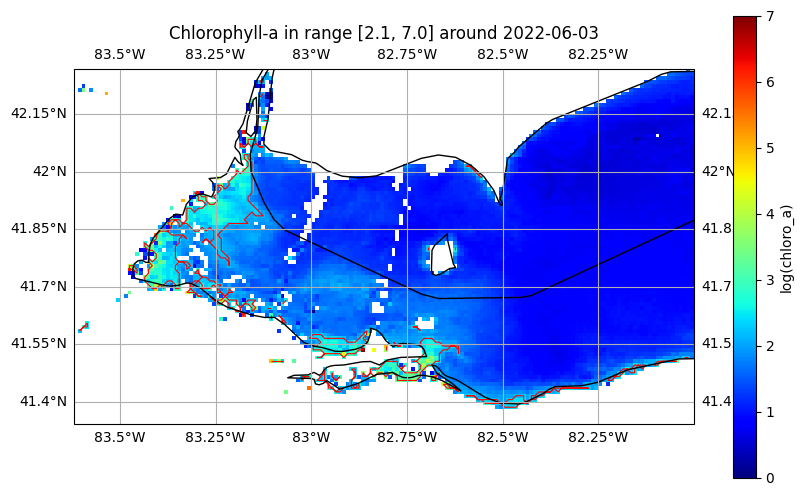

In [12]:
plot_chla_image(data_path="/content/drive/MyDrive/Images2/composite_data_S3_2022-06-03.npy",
                metadata_path="/content/drive/MyDrive/Images2/composite_metadata_S3_2022-06-03.pkl",
                band_index=21, min_thresh=2.1, max_thresh=7.0)

## Aggregate all the data into a huge numpy array

In [13]:
def nanratio(arr):
  # Count total values
  total = arr.size

  # Count NaNs
  nan_count = np.isnan(arr).sum()

  # Count non-NaNs
  non_nan_count = total - nan_count

  # Ratio of NaNs to non-NaNs
  ratio = nan_count * 100 / total if non_nan_count != 0 else np.inf

  return ratio

In [14]:
# Directory containing the files
directory = "/content/drive/MyDrive/Images2"
datafiles = []
metadatafiles = []

# Example: rename all .txt files by adding a prefix
for filename in os.listdir(directory):
    if filename.startswith("composite_data_S3_"):
        datafiles.append(filename)
    if filename.startswith("composite_metadata_S3_"):
        metadatafiles.append(filename)

datafiles.sort()
metadatafiles.sort()
allfiles = zip(datafiles, metadatafiles)

In [15]:
# Initialize list to collect arrays
array_list = []
dates_list = []
dropcount_allnan = 0
dropcount_lesspixels = 0

for npy,metanpy in list(allfiles):
    #print(npy, metanpy)
    datapath = f'{directory}/{npy}'
    metadatapath = f'{directory}/{metanpy}'
    lat, lon, start_date, dailydata = get_numpy_data_from_file(datapath, metadatapath)
    #print(lat.shape, lon.shape, dailydata.shape)

    if np.isnan(dailydata).all() == True:
      print(f'Skipping file {datapath} as all data is NaN')
      dropcount_allnan += 1
      continue

    #if nanratio(dailydata[:,:,:,21]) > 80:
    #  print(f'Skipping file {datapath} as more than 70% of data is NaN')
    #  dropcount += 1
    #  continue

    # count of non-Nan data for chla should at least be G_validPixelsInImage for good training
    if np.count_nonzero(~np.isnan(dailydata[:,:,:,21])) < G_validPixelsInImage:
      #print(f'Skipping file {datapath} as less than {G_validPixelsInImage} non-NaN data')
      dropcount_lesspixels += 1
      continue

    array_list.append(dailydata)
    dates_list.append(start_date)

# Stack them into shape (N, H, W, C)
stacked_array = np.concatenate(array_list, axis=0)

stacked_array = stacked_array[:,:,:,21:22] #ignore all other channels since they are NaNs

# get count of all Nans in stacked_array
print(f'Shape of stacked array: {stacked_array.shape}; Min: {np.nanmin(stacked_array)}, Max: {np.nanmax(stacked_array)}')
print(f'Count of all NaN data: {np.count_nonzero(np.isnan(stacked_array))}')
print(f'Count of all non-Nan data: {np.count_nonzero(~np.isnan(stacked_array))}')

print(f'Dropped {dropcount_allnan} images due to all NaN data')
print(f'Dropped {dropcount_lesspixels} images due to less than {G_validPixelsInImage} non-NaN data')

Skipping file /content/drive/MyDrive/Images2/composite_data_S3_2017-01-13.npy as all data is NaN
Skipping file /content/drive/MyDrive/Images2/composite_data_S3_2017-01-19.npy as all data is NaN
Skipping file /content/drive/MyDrive/Images2/composite_data_S3_2017-01-22.npy as all data is NaN
Skipping file /content/drive/MyDrive/Images2/composite_data_S3_2017-01-28.npy as all data is NaN
Skipping file /content/drive/MyDrive/Images2/composite_data_S3_2017-02-12.npy as all data is NaN
Skipping file /content/drive/MyDrive/Images2/composite_data_S3_2017-03-20.npy as all data is NaN
Skipping file /content/drive/MyDrive/Images2/composite_data_S3_2017-03-26.npy as all data is NaN
Skipping file /content/drive/MyDrive/Images2/composite_data_S3_2017-03-29.npy as all data is NaN
Skipping file /content/drive/MyDrive/Images2/composite_data_S3_2017-09-22.npy as all data is NaN
Skipping file /content/drive/MyDrive/Images2/composite_data_S3_2017-11-15.npy as all data is NaN
Skipping file /content/drive/M

In [16]:
# ratios = []
# for i in range(len(stacked_array)):
#   ratios.append(nanratio(stacked_array[i]))

In [17]:
# np.nanmin(ratios), np.nanmax(ratios), len(ratios)

In [18]:
# # Plot
# plt.figure(figsize=(8, 4))
# plt.plot(ratios, marker='o', linestyle='-')
# plt.xlabel("Time Index from 2017/01")
# plt.ylabel("Percentage of NaN data in image")
# plt.title("Pct (NaN) vs Time")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [19]:
# Find gaps in dates_list, exceeding 14 days
gaps = []
for i in range(1, len(dates_list)):
    diff = (dates_list[i] - dates_list[i-1]).days
    if diff > 10:
        gaps.append((dates_list[i], dates_list[i-1], diff))

In [20]:
gaps

[(datetime.datetime(2017, 2, 15, 0, 0),
  datetime.datetime(2017, 2, 3, 0, 0),
  12),
 (datetime.datetime(2017, 4, 1, 0, 0),
  datetime.datetime(2017, 3, 8, 0, 0),
  24),
 (datetime.datetime(2017, 4, 19, 0, 0),
  datetime.datetime(2017, 4, 1, 0, 0),
  18),
 (datetime.datetime(2017, 6, 24, 0, 0),
  datetime.datetime(2017, 6, 12, 0, 0),
  12),
 (datetime.datetime(2017, 8, 2, 0, 0),
  datetime.datetime(2017, 7, 21, 0, 0),
  12),
 (datetime.datetime(2017, 11, 6, 0, 0),
  datetime.datetime(2017, 10, 22, 0, 0),
  15),
 (datetime.datetime(2017, 11, 21, 0, 0),
  datetime.datetime(2017, 11, 9, 0, 0),
  12),
 (datetime.datetime(2018, 2, 28, 0, 0),
  datetime.datetime(2017, 12, 9, 0, 0),
  81),
 (datetime.datetime(2018, 4, 8, 0, 0),
  datetime.datetime(2018, 3, 27, 0, 0),
  12),
 (datetime.datetime(2018, 4, 29, 0, 0),
  datetime.datetime(2018, 4, 11, 0, 0),
  18),
 (datetime.datetime(2018, 7, 1, 0, 0),
  datetime.datetime(2018, 6, 10, 0, 0),
  21),
 (datetime.datetime(2018, 8, 30, 0, 0),
  dateti

### Look for Outliers

In [21]:
positives = np.nansum(stacked_array > 0)
negatives = np.nansum(stacked_array < 0)
total = positives + negatives

# Count of all values greater than 0
print(f'Count all elements greater than 0: {positives} [{(positives*100)/total}]%')

# Count of all values less than 0
print(f'Count all elements less than 0: {negatives} [{(negatives*100)/total}]%')

# Count of all values less than -0.00016
print(f'Count all elements less than -0.00016: {np.sum(stacked_array < -0.00016)}')

Count all elements greater than 0: 4142072 [100.0]%
Count all elements less than 0: 0 [0.0]%
Count all elements less than -0.00016: 0


In [22]:
# print min and max for the entire stacked_array (across all time intervals)
print(f'For whole dataset: Min - {np.nanmin(stacked_array)} Max - {np.nanmax(stacked_array)}')

# print min and max for week 100
print(f'For sample 100: Min - {np.nanmin(stacked_array[100])} Max - {np.nanmax(stacked_array[100])}')

reflectance_threshold = G_maxChla

count = 0
for i in range(len(stacked_array)):
  if (np.nanmax(stacked_array[i]) > reflectance_threshold):
    for j in range(0,1):
      if (np.nanmax(stacked_array[i][:,:,j]) > reflectance_threshold):
        ttl = np.nansum(stacked_array[i][:,:,j] > reflectance_threshold)
        if ttl > 10:
          print(f'Week {dates_list[i]}: Total: {ttl}, Max: {np.nanmax(stacked_array[i])}')
        count += ttl

print(f'Count of pixels above {G_maxChla} value: {count} out of {positives} [{count*100/positives} %]')


For whole dataset: Min - 0.0010000000474974513 Max - 1000.0
For sample 100: Min - 1.9371578693389893 Max - 832.2864990234375
Week 2017-09-01 00:00:00: Total: 13, Max: 1000.0
Week 2017-09-16 00:00:00: Total: 22, Max: 1000.0
Week 2017-09-25 00:00:00: Total: 23, Max: 1000.0
Week 2017-09-28 00:00:00: Total: 41, Max: 1000.0
Week 2021-08-04 00:00:00: Total: 20, Max: 1000.0
Week 2021-08-10 00:00:00: Total: 17, Max: 1000.0
Week 2023-07-07 00:00:00: Total: 19, Max: 1000.0
Week 2023-07-25 00:00:00: Total: 17, Max: 1000.0
Week 2023-09-14 00:00:00: Total: 11, Max: 1000.0
Week 2023-12-16 00:00:00: Total: 17, Max: 1000.0
Week 2024-06-22 00:00:00: Total: 23, Max: 1000.0
Count of pixels above 600 value: 925 out of 4142072 [0.02233181847152826 %]


### Clamp outliers from 0.0 to G_maxChla

In [23]:
# we can clamp all the chla values to G_maxChla
# and clamp all the minimum to 0.0
stacked_array = np.clip(stacked_array, a_min = 0.001, a_max=G_maxChla)

#stacked_array[:,:,:,0] = np.log(stacked_array[:,:,:,0])

print(f'Shape of stacked array: {stacked_array.shape}; Min: {np.nanmin(stacked_array)}, Max: {np.nanmax(stacked_array)}')


Shape of stacked array: (568, 93, 163, 1); Min: 0.0010000000474974513, Max: 600.0


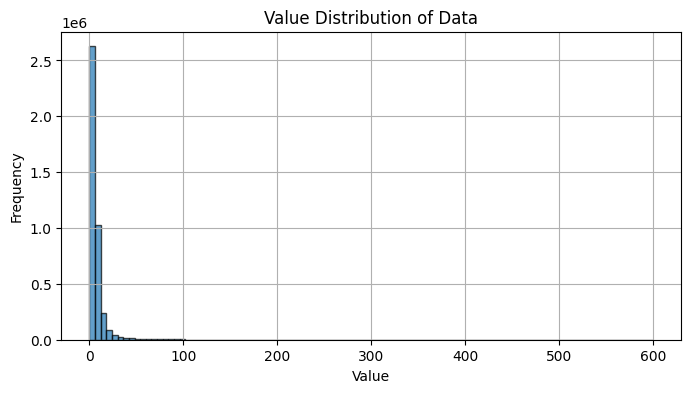

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Example data
x = stacked_array[:,:,:,0]
x = x[np.isfinite(x)]  # Remove NaNs if present

# Histogram
plt.figure(figsize=(8, 4))
plt.hist(x, bins=100, edgecolor='k', alpha=0.7)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Value Distribution of Data")
plt.grid(True)
plt.show()


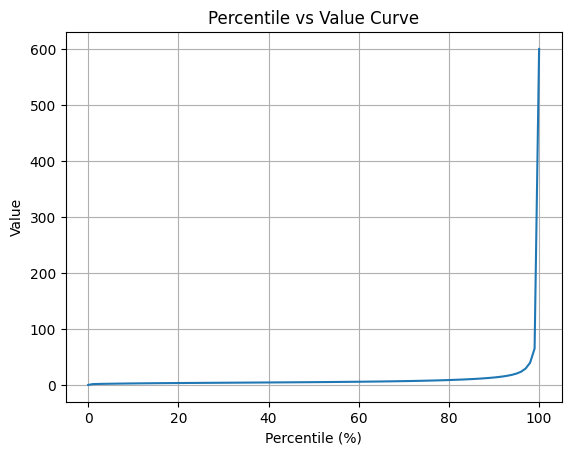

In [25]:
import numpy as np
import matplotlib.pyplot as plt

x = stacked_array[:,:,:,0]
x = x[np.isfinite(x)]

percentiles = np.percentile(x, np.arange(0, 101, 1))
plt.plot(np.arange(101), percentiles)
plt.title("Percentile vs Value Curve")
plt.xlabel("Percentile (%)")
plt.ylabel("Value")
plt.grid(True)


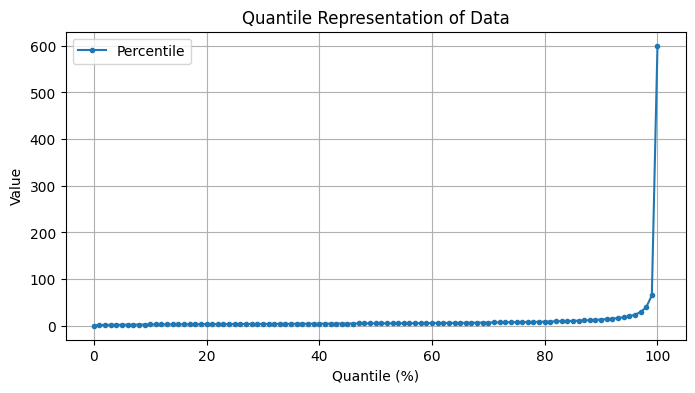

In [26]:
import numpy as np
import matplotlib.pyplot as plt

x = stacked_array[:,:,:,0]

# Ignore NaNs if needed
x = x[np.isfinite(x)]

# Quantiles from 0% to 100%
quantiles = np.linspace(0, 100, 101)
values = np.percentile(x, quantiles)

plt.figure(figsize=(8, 4))
plt.plot(quantiles, values, marker='.', label='Percentile')
plt.xlabel('Quantile (%)')
plt.ylabel('Value')
plt.title('Quantile Representation of Data')
plt.grid(True)
plt.legend()
plt.show()


### Global list of Rmax values for each channel

In [27]:
# def normalize(data, eps=1e-8):
#     Rmax = [0] * 1

#     # Ensure float for NaN support
#     data = data.astype(np.float32)

#     # Incoming data shape is (223, 93,163, 11)
#     # Let's create Rmax per channel, so that the normalization happens for
#     # each wavelength

#     for i in range(1):
#       Rmax[i] = np.nanmax(data[:,:,:,i])
#       print(f'Rmax[{i}]: {Rmax[i]}')
#       data[:,:,:,i] = (data[:,:,:,i] / Rmax[i]) * 2 - 1
#       #data[:,:,:,i] = ((data[:,:,:,i] + Rmax[i]) / Rmax[i]) - 1

#     return data, Rmax

In [28]:
def normalize(data, eps=1e-8):
    # Incoming data (D, 93, 163, 1)
    D, H, W, C = data.shape
    normed_data = np.copy(data)
    stats = {}

    for c in range(C):
        values = data[..., c]
        median = np.nanmedian(values)
        q5 = np.nanpercentile(values, 10)
        q95 = np.nanpercentile(values, 90)
        iqr = q95 - q5 if q95 != q5 else 1.0

        normed_data[..., c] = (data[..., c] - median) / iqr
        stats[c] = (median, iqr)
        normed_data = np.tanh(normed_data)

    return normed_data, stats


In [29]:
# def denormalize(data, rmax):
#   for i in range(1):
#     data[:,:,:,i] = ((data[:,:,:,i] + 1) / 2) * rmax[i]
#     #data[:,:,:,i] = data[:,:,:,i] * rmax[i]

#   return (data)

In [30]:
def denormalize(normed_data, stats):
    """
    Reverse robust normalization for selected channels.

    Parameters:
        normed_data: normalized array (B, T, H, W, C)
        stats: dict from normalization step

    Returns:
        denormed_data: denormalized array
    """

    denormed_input = np.copy(normed_data)
    denormed_input = np.clip(denormed_input, -0.999999, 0.999999)
    denormed_scaled = np.arctanh(denormed_input)
    for c, (median, iqr) in stats.items():
        denormed_scaled[..., c] = denormed_scaled[..., c] * iqr + median
    return denormed_scaled

In [31]:
# Validate the normalization/denormalization to ensure it scales up/down correct.

orig_array = stacked_array[:, :, :, :1].copy()
print(f'Original before normalization: Min: {np.nanmin(orig_array)}, Max: {np.nanmax(orig_array)}, Sum: {np.nansum(orig_array)}')
norm, GRmax = normalize(orig_array)
print(f'After   normalization: Min: {np.nanmin(norm)}, Max: {np.nanmax(norm)}, Sum: {np.nansum(norm)}')
denorm = denormalize(norm, GRmax)
print(f'After denormalization Min: {np.nanmin(denorm)}, Max: {np.nanmax(denorm)}, Sum: {np.nansum(denorm)}')

if np.nansum(denorm) == np.nansum(orig_array):
  print('Success')

del orig_array, denorm


Original before normalization: Min: 0.0010000000474974513, Max: 600.0, Sum: 34298492.0
After   normalization: Min: -0.4357447326183319, Max: 1.0, Sum: 448193.71875
After denormalization Min: 0.0009999275207519531, Max: 81.7955093383789, Sum: 31654932.0


In [32]:
GRmax

{0: (np.float32(4.951973), np.float32(10.602425))}

### Adding time-marker channels

In [33]:
# --- 1. Add seasonal sin/cos encodings ---
def add_time_features(data, dates):
    T, H, W, C = data.shape
    #dates = [start_date + timedelta(days=8*i) for i in range(T)]
    day_of_year = np.array([d.timetuple().tm_yday for d in dates])
    sin_doy = np.sin(2 * np.pi * day_of_year / 365)
    cos_doy = np.cos(2 * np.pi * day_of_year / 365)

    sin_doy = sin_doy[:, None, None, None]
    cos_doy = cos_doy[:, None, None, None]

    sin_doy = np.tile(sin_doy, (1, H, W, 1))
    cos_doy = np.tile(cos_doy, (1, H, W, 1))

    return np.concatenate([data, sin_doy, cos_doy], axis=-1)  # (T, H, W, C+2)


## Main processing

Extract mask: Extract the mask across all days and all channels.

Normalize: The stacked array needs to be MinMax scaled between -1 and +1

In [34]:
valid_mask = np.isfinite(stacked_array).astype(np.float32)  # 1 where finite, 0 where NaN

scaled_array, GRmax = normalize(stacked_array, eps=1e-8)

print(stacked_array.shape, scaled_array.shape, valid_mask.shape)

(568, 93, 163, 1) (568, 93, 163, 1) (568, 93, 163, 1)


### Spot check both scaled and unscaled data

In [35]:
# scaled_array is the original dataset: # (225, 93, 163, 11)
print(f'Original: {scaled_array.shape}')

# Add two more dimensions for time
scaled_array = add_time_features(scaled_array, dates_list)
print(f'TimeDims added: {scaled_array.shape}')

# Create a mask across all data (across days, lat, lon, channels)
mask = ~np.isnan(scaled_array[..., :1]).any(axis=-1, keepdims=True)

print(f'Mask shape: {mask.shape}')

# Replace NaNs with a -1.0 (lowest value)
scaled_array[..., :1] = np.nan_to_num(scaled_array[..., :1], nan=-1.0)

# Add the mask as a channel to the original array
data = np.concatenate([scaled_array, mask], axis=-1)

# New dimension should be (225, 93, 163, 13)
print(f'Mask added: {data.shape}')
print(f'Non-masked Pixels: {np.count_nonzero(mask)}')
print(f'Masked Pixels: {np.count_nonzero(~mask)}')

# --- Create train sequences ---

# Create the X and y datasets for training

X = []
y = []

seq_len = 5  # Adjustable
for i in range(len(data) - seq_len):
    X.append(data[i:i+seq_len])
    y.append(data[i+seq_len])  # predict the next frame

X = np.array(X)  # (samples, seq, H, W, channels)
y = np.array(y)  # (samples, H, W, channels)

print(X.shape, y.shape)

Original: (568, 93, 163, 1)
TimeDims added: (568, 93, 163, 3)
Mask shape: (568, 93, 163, 1)
Mask added: (568, 93, 163, 4)
Non-masked Pixels: 4142072
Masked Pixels: 4468240
(563, 5, 93, 163, 4) (563, 93, 163, 4)


### Custom MSE loss function
Note that we are applying a mask corresponding to each output image.

In [36]:
def masked_mse_loss(y_true, y_pred):
    print(f'MSE incoming: True: {y_true.shape}  Pred: {y_pred.shape}')
    # Split last channel as mask (assumes last channel is the mask)
    mask = y_true[..., -1]  # shape: (B, H, W)
    true = y_true[..., :1]  # shape: (B, H, W, C)
    print(mask.shape, true.shape, y_pred.shape)

    mask = tf.expand_dims(mask, axis=-1)  # shape: (B, H, W, 1)

    squared_error = tf.square(true - y_pred)
    masked_error = squared_error * mask

    # Avoid dividing by zero
    masked_mse = tf.reduce_sum(masked_error) / tf.reduce_sum(mask + 1e-8)
    return masked_mse


In [37]:
def masked_ssim_loss_with_mask_in_ytrue(y_true_with_mask, y_pred, max_val=1.0):
    """
    Compute masked SSIM loss, assuming mask is in the last channel of y_true.

    Args:
        y_true_with_mask: Tensor of shape (B, H, W, C+1) — last channel is mask
        y_pred: Tensor of shape (B, H, W, C)
        max_val: Maximum value of image (typically 1.0)

    Returns:
        Scalar loss: 1 - masked SSIM
    """
    # Split image and mask
    y_true = y_true_with_mask[..., 0:1]  # (B, H, W, C)
    mask = y_true_with_mask[..., -1:]    # (B, H, W, 1)

    # Compute per-sample SSIM (returns shape (B,))
    ssim_map = tf.image.ssim(y_true, y_pred, max_val=max_val)

    # Compute average mask value per image (B,)
    mask_weight = tf.reduce_mean(mask, axis=[1, 2, 3])
    mask_weight = tf.where(mask_weight == 0, tf.ones_like(mask_weight), mask_weight)

    # Apply sample-wise weights
    weighted_ssim = tf.reduce_sum(ssim_map * mask_weight) / tf.reduce_sum(mask_weight)

    return 1.0 - weighted_ssim


In [38]:
# Assuming X.shape = (num_samples, ...) where samples are ordered in time

train_split_index = int(0.6 * len(X))
val_split_index = int(0.8 * len(X))

#split_index = int(0.8 * len(X))

X_train = X[:train_split_index][:,:,:,:,0:3]
X_val = X[train_split_index:val_split_index][:,:,:,:,0:3]

y_train = y[:train_split_index]
y_val = y[train_split_index:val_split_index]

X_test = X[val_split_index:][:,:,:,:,0:3]
y_test = y[val_split_index:]

print(f'X Train: {X_train.shape} Val: {X_val.shape} Test: {X_test.shape}')
print(f'Y Train: {y_train.shape} Val: {y_val.shape} Test: {y_test.shape}')
print(f'X_train: Min {np.nanmin(X_train)}, Max {np.nanmax(X_train)}')
print(f'X_val: Min {np.nanmin(X_val)}, Max {np.nanmax(X_val)}')
print(f'X_test: Min {np.nanmin(X_test)}, Max {np.nanmax(X_test)}')

X Train: (337, 5, 93, 163, 3) Val: (113, 5, 93, 163, 3) Test: (113, 5, 93, 163, 3)
Y Train: (337, 93, 163, 4) Val: (113, 93, 163, 4) Test: (113, 93, 163, 4)
X_train: Min -1.0, Max 1.0
X_val: Min -1.0, Max 1.0
X_test: Min -1.0, Max 1.0


### Build the model

In [39]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, ConvLSTM2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

# model = Sequential([
#     # Muthu: Changed input shape from 4 -> 3; Conv to avoid mask channel
#     Input(shape=(None, 93, 163, 3)),
#     TimeDistributed(Conv2D(32, (3, 3), activation='tanh', padding='same')),
#     TimeDistributed(BatchNormalization()),
#     TimeDistributed(Conv2D(64, (3, 3), activation='tanh', padding='same')),
#     TimeDistributed(BatchNormalization()),

#     ConvLSTM2D(64, (3, 3), padding='same', return_sequences=False, data_format='channels_last'),
#     BatchNormalization(),

#     Conv2D(1, (3, 3), padding='same', activation='tanh')  # output 1-channel next frame
# ])

model = Sequential([
    # Muthu: Changed input shape from 4 -> 3; Conv to avoid mask channel
    Input(shape=(None, 93, 163, 3)),
    TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same')),
    TimeDistributed(BatchNormalization()),

    ConvLSTM2D(64, (3, 3), padding='same', return_sequences=False, data_format='channels_last'),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    Conv2D(1, (1, 1), activation='tanh', padding='same')  # if output is normalized to [-1, +1]

])

#model.compile(optimizer=Adam(1e-4), loss=masked_mse_loss)
def loss_fn(y_true, y_pred):
  if G_use_ssim_loss:
    return masked_ssim_loss_with_mask_in_ytrue(y_true, y_pred)
  else:
    return masked_mse_loss(y_true, y_pred)

model.compile(optimizer=Adam(1e-4), loss=loss_fn)


In [40]:
# import keras
# from keras import layers

# # Construct the input layer with no definite frame size.
# inp = layers.Input(shape=(None, *X_train.shape[2:]))

# # We will construct 3 `ConvLSTM2D` layers with batch normalization,
# # followed by a `Conv2D` layer for the spatiotemporal outputs.
# x = layers.ConvLSTM2D(
#     filters=64,
#     kernel_size=(3, 3),
#     padding="same",
#     return_sequences=True,
#     activation="tanh",
# )(inp)
# x = layers.BatchNormalization()(x)
# x = layers.ConvLSTM2D(
#     filters=64,
#     kernel_size=(3, 3),
#     padding="same",
#     return_sequences=True,
#     activation="tanh",
# )(x)
# x = layers.BatchNormalization()(x)
# x = layers.ConvLSTM2D(
#     filters=64,
#     kernel_size=(1, 1),
#     padding="same",
#     return_sequences=False,
#     activation="tanh",
# )(x)
# x = layers.Conv2D(
#     filters=1, kernel_size=(3, 3), activation="tanh", padding="same"
# )(x)

# # Next, we will build the complete model and compile it.
# model = keras.models.Model(inp, x)
# model.compile(
#     loss=masked_mse_loss,
#     optimizer=keras.optimizers.Adam(1e-4),
# )


In [41]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Epoch 1/25
MSE incoming: True: (None, 93, 163, 4)  Pred: (None, 93, 163, 1)
(None, 93, 163) (None, 93, 163, 1) (None, 93, 163, 1)
MSE incoming: True: (None, 93, 163, 4)  Pred: (None, 93, 163, 1)
(None, 93, 163) (None, 93, 163, 1) (None, 93, 163, 1)
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 0.2234MSE incoming: True: (None, 93, 163, 4)  Pred: (None, 93, 163, 1)
(None, 93, 163) (None, 93, 163, 1) (None, 93, 163, 1)
85/85 ━━━━━━━━━━━━━━━━━━━━ 38s 301ms/step - loss: 0.2225 - val_loss: 0.1259
Epoch 2/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 17s 206ms/step - loss: 0.0816 - val_loss: 0.0591
Epoch 3/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 17s 203ms/step - loss: 0.0573 - val_loss: 0.0535
Epoch 4/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 17s 201ms/step - loss: 0.0553 - val_loss: 0.0515
Epoch 5/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 17s 201ms/step - loss: 0.0519 - val_loss: 0.0529
Epoch 6/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 17s 201ms/step - loss: 0.0514 - val_loss: 0.0515
Epoch 7/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 17s 201ms/step - loss: 0.044

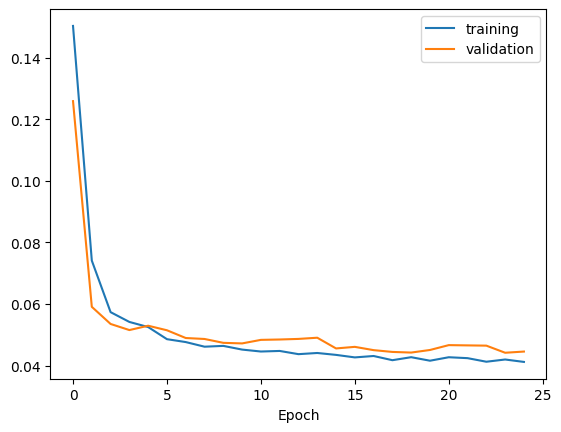

In [42]:
if include_training:
  history = model.fit(
        x=X_train,                   # shape: (N, T, H, W, C)
        y=y_train,                   # shape: (N, H, W, 11)
        validation_data=(X_val, y_val),
        epochs=25,
        batch_size=4)
  plt.plot(history.history['loss'], label = 'training')
  plt.plot(history.history['val_loss'], label = 'validation')
  plt.legend()
  plt.xlabel("Epoch")
  plt.show()

In [43]:
#Fix labels as needed


In [44]:
# prompt: save the trained model to local file
if include_training:
  model.save('/content/drive/MyDrive/MIDS-210/CNN-LSTM/my_chla_model.keras')


In [45]:
def predict_and_denorm(model, X_test, y_test):
  y_pred = model.predict(X_test)

  # The last channel in y_test is the mask channel
  valid_mask = y_test[..., -1].astype(bool)
  true_frame = y_test[..., :1]
  print(f'true_frame: {true_frame.shape}; valid_mask: {valid_mask.shape}')
  pred_frame = y_pred[0, :, :, :1]

  # Broadcast the mask to all 11 channels
  true = np.where(valid_mask[..., np.newaxis], true_frame, np.nan)
  pred = np.where(valid_mask[..., np.newaxis], pred_frame, np.nan)

  # Add an extra dimension simulating the days dimension
  true = np.expand_dims(true, axis=0)
  pred = np.expand_dims(pred, axis=0)

  # Bring values back to [0,GRmax] range
  true = denormalize(true, GRmax)
  pred = denormalize(pred, GRmax)

  error = np.where(valid_mask[..., np.newaxis], pred - true, np.nan)
  return true, pred, error




In [46]:
def plot_chla(image, date, min_thresh=2.5, max_thresh=7.0, from_dataset_only=True):

    seldate = dates_list[date]

    plotdate = str(seldate.date())

    data_path=f"/content/drive/MyDrive/Images2/composite_data_S3_{plotdate}.npy"
    metadata_path=f"/content/drive/MyDrive/Images2/composite_metadata_S3_{plotdate}.pkl"
    lat, lon, date2, data = get_numpy_data_from_file(data_path, metadata_path)

    # need to use log because of the spread of data
    orig = data[0][:,:,21]
    print(f'Orig {date2} Nan: {np.count_nonzero(np.isnan(orig))} Non-Nan: {np.count_nonzero(~np.isnan(orig))}')
    print(f'Orig Min: {np.nanmin(orig)}, Max: {np.nanmax(orig)}')
    normorig = np.log(orig)
    print(f'Orig Min(log): {np.nanmin(normorig)}, Max(log): {np.nanmax(normorig)}')

    print()

    # this image from the training data or predicted data
    chla = image[0][:,:,0]
    print(f'Image {plotdate} Nan: {np.count_nonzero(np.isnan(chla))} Non-Nan: {np.count_nonzero(~np.isnan(chla))}')
    print(f'Image Min: {np.nanmin(chla)}, Max: {np.nanmax(chla)}')
    normd = np.log(chla)
    print(f'Image Min(log): {np.nanmin(normd)}, Max(log): {np.nanmax(normd)}')

    # Filter the higher value of chla
    mask = (normd > min_thresh) & (normd < max_thresh) & np.isfinite(normd)  # True between thresholds

    # Set elements where mask is False to NaN
    # selected = np.where(mask, normd, np.nan)
    selected = np.where(mask, normd, 0)

    print(f'Selected: np.min={np.nanmin(selected), np.max(np.nanmax(selected))}')

    selected_after = selected.astype(np.uint8)

    # 4. Use OpenCV to find contours
    contours, _ = cv2.findContours(selected_after, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # --- Plot on Cartopy ---
    # Create subplots: 1 row, 2 columns
    if from_dataset_only:
      fig, ax = plt.subplots(1, 1, figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    else:
      fig, ax = plt.subplots(1, 2, figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

    for ax in fig.axes:
      ax.coastlines(resolution='10m')
      ax.add_feature(cfeature.BORDERS)
      ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
      ax.set_extent([-83.62, -82.0, 41.34, 42.27], crs=ccrs.PlateCarree())
      ax.gridlines(draw_labels=True)

    if from_dataset_only:
      fig.suptitle(f"Chlorophyll-a in range [{min_thresh}, {max_thresh}] around {seldate.date()}", fontsize=12)
      im2 = fig.axes[0].pcolormesh(lon, lat, normd, cmap='jet', shading='auto', vmin=0, vmax=7, transform=ccrs.PlateCarree())
      cbar = plt.colorbar(im2, ax=fig.axes[0], orientation='vertical', label='log(chloro_a)')
    else:
      fig.suptitle(f"Chlorophyll-a in range [{min_thresh}, {max_thresh}] around {seldate.date()}", fontsize=12)
      # Plot Orig
      im1 = fig.axes[0].pcolormesh(lon, lat, normorig, cmap='jet', shading='auto', vmin=0, vmax=7, transform=ccrs.PlateCarree())
      # Plot reflectance
      im2 = fig.axes[1].pcolormesh(lon, lat, normd, cmap='jet', shading='auto', vmin=0, vmax=7, transform=ccrs.PlateCarree())
      cbar = plt.colorbar(im2, ax=fig.axes[0], orientation='vertical', label='log(chloro_a)')

    # Add colorbar and labels


    # 5. Overlay contours back on map
    for cnt in contours:
        # cnt is an array of shape (N, 1, 2) with (row, col) indices
        cnt = cnt.squeeze()  # shape (N, 2)
        if cnt.ndim != 2:
            continue  # skip if contour is malformed

        # Convert from array indices to lat/lon
        y_idx, x_idx = cnt[:, 1], cnt[:, 0]
        contour_lons = lon[x_idx]
        contour_lats = lat[y_idx]

        #ax.plot(contour_lons, contour_lats, color='red', linewidth=1.2, transform=ccrs.PlateCarree())
        poly = Polygon(
            np.column_stack((contour_lons, contour_lats)),
            closed=True,
            facecolor='none',
            edgecolor='green',
            linewidth=0.8,
            alpha=1.0,
            transform=ccrs.PlateCarree()
        )
        #fig.axes[1].add_patch(poly)

    #plt.title(f"Chlorophyll-a in range [{min_thresh}, {max_thresh}] around {seldate.date()}")
    #plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle

    plt.show()


In [47]:
def plot_chla_true_pred(true, pred, date, min_thresh=2.5, max_thresh=7.0):

    seldate = dates_list[date]

    plotdate = str(seldate.date())
    data_path=f"/content/drive/MyDrive/Images2/composite_data_S3_{plotdate}.npy"
    metadata_path=f"/content/drive/MyDrive/Images2/composite_metadata_S3_{plotdate}.pkl"
    lat, lon, date2, data = get_numpy_data_from_file(data_path, metadata_path)

    # need to use log because of the spread of data
    chlaT = true[0][:,:,0]
    print(f'True {date2} Nan: {np.count_nonzero(np.isnan(chlaT))} Non-Nan: {np.count_nonzero(~np.isnan(chlaT))}')
    print(f'True Min: {np.nanmin(chlaT)}, Max: {np.nanmax(chlaT)}')
    normTrue = np.log(chlaT)
    print(f'True Min(log): {np.nanmin(normTrue)}, Max(log): {np.nanmax(normTrue)}')

    print()

    # this image from the training data or predicted data
    chlaP = pred[0][:,:,0]
    print(f'Pred {plotdate} Nan: {np.count_nonzero(np.isnan(chlaP))} Non-Nan: {np.count_nonzero(~np.isnan(chlaP))}')
    print(f'Pred Min: {np.nanmin(chlaP)}, Max: {np.nanmax(chlaP)}')
    normPred = np.log(chlaP)
    print(f'Pred Min(log): {np.nanmin(normPred)}, Max(log): {np.nanmax(normPred)}')

    # Filter the higher value of chla
    mask = (normPred > min_thresh) & (normPred < max_thresh) & np.isfinite(normPred)  # True between thresholds

    # Set elements where mask is False to NaN
    # selected = np.where(mask, normd, np.nan)
    selected = np.where(mask, normPred, 0)

    print(f'Selected: np.min={np.nanmin(selected), np.max(np.nanmax(selected))}')

    selected_after = selected.astype(np.uint8)

    # 4. Use OpenCV to find contours
    contours, _ = cv2.findContours(selected_after, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # --- Plot on Cartopy ---
    # Create subplots: 1 row, 2 columns
    fig, ax = plt.subplots(1, 2, figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    ax[0].set_title("True")
    ax[1].set_title("Pred")
    for ax in fig.axes:
      ax.coastlines(resolution='10m')
      ax.add_feature(cfeature.BORDERS)
      ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
      ax.set_extent([-83.62, -82.0, 41.34, 42.27], crs=ccrs.PlateCarree())
      gl = ax.gridlines(draw_labels=True)

      # Set font size for x and y labels
      gl.xlabel_style = {'size': 6}
      gl.ylabel_style = {'size': 6}

      fig.suptitle(f"Chlorophyll-a in range [{min_thresh}, {max_thresh}] around {seldate.date()}", fontsize=12)

      im1 = fig.axes[0].pcolormesh(lon, lat, normTrue, cmap='jet', shading='auto', vmin=0, vmax=7, transform=ccrs.PlateCarree())
      im2 = fig.axes[1].pcolormesh(lon, lat, normPred, cmap='jet', shading='auto', vmin=0, vmax=7, transform=ccrs.PlateCarree())

    #cbar = plt.colorbar(im2, ax=fig.axes[1], orientation='vertical', label='log(chloro_a)')

    # 5. Overlay contours back on map
    for cnt in contours:
        # cnt is an array of shape (N, 1, 2) with (row, col) indices
        cnt = cnt.squeeze()  # shape (N, 2)
        if cnt.ndim != 2:
            continue  # skip if contour is malformed

        # Convert from array indices to lat/lon
        y_idx, x_idx = cnt[:, 1], cnt[:, 0]
        contour_lons = lon[x_idx]
        contour_lats = lat[y_idx]

        #ax.plot(contour_lons, contour_lats, color='red', linewidth=1.2, transform=ccrs.PlateCarree())
        poly = Polygon(
            np.column_stack((contour_lons, contour_lats)),
            closed=True,
            facecolor='none',
            edgecolor='green',
            linewidth=0.8,
            alpha=1.0,
            transform=ccrs.PlateCarree()
        )
        #fig.axes[1].add_patch(poly)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle

    plt.show()


In [48]:
def get_denormalized_data(X_frame, y_true, seq_no=0):

  # Why do we need y_true?
  # The last channel in y_true is the mask channel
  # We cannot use X_frame, because we have stripped out the mask channel prior
  # to training
  valid_mask = y_true[..., -1].astype(bool)

  true_frame = X_frame[:,seq_no,:,:,0:1]

  #print(f'true_frame: {true_frame.shape}; valid_mask: {valid_mask.shape}')
  #print(f'min: {np.nanmin(true_frame)} max: {np.nanmax(true_frame)}')

  # Broadcast the mask to all channels; There is only one useful channel here.
  true = np.where(valid_mask[..., np.newaxis], true_frame, np.nan)

  #print(f'min: {np.nanmin(true)} max: {np.nanmax(true)}')

  # Add an extra dimension simulating the days dimension
  # true = np.expand_dims(true, axis=0)

  #print(f'min: {np.nanmin(true)} max: {np.nanmax(true)}, Shape: {true.shape}')

  # Bring values back to [0,1000] range
  true = denormalize(true, GRmax)

  #print(f'min: {np.nanmin(true)} max: {np.nanmax(true)}, GRmax: {GRmax}')

  return true

In [49]:
# Load from saved model
from tensorflow.keras.models import load_model
mymodel = load_model('/content/drive/MyDrive/MIDS-210/CNN-LSTM/my_chla_model.keras', custom_objects={'loss_fn': loss_fn})

sample = 407

date = dates_list[sample]

print(f'Sample Start Date: {dates_list[sample]}')

X_test = X[sample:sample+1,...][:,:,:,:,0:3]
y_test = y[sample]

print(X_test.shape, y_test.shape)


Sample Start Date: 2023-04-14 00:00:00
(1, 5, 93, 163, 3) (93, 163, 4)


In [50]:
for seq_no in range(5):
  xdenorm = get_denormalized_data(X_test[...,0:1], y_test, seq_no)
  #plot_chla(xdenorm, sample+seq_no)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
true_frame: (93, 163, 1); valid_mask: (93, 163)
Orig 2023-05-08 00:00:00 Nan: 7624 Non-Nan: 7535
Orig Min: 1.8628538846969604, Max: 363.5261535644531
Orig Min(log): 0.6221096515655518, Max(log): 5.895851135253906

Image 2023-05-08 Nan: 7624 Non-Nan: 7535
Image Min: 1.862854236709163, Max: 81.86544532718445
Image Min(log): 0.6221098473932145, Max(log): 4.40507698885171
Selected: np.min=(np.float64(0.0), np.float64(4.40507698885171))


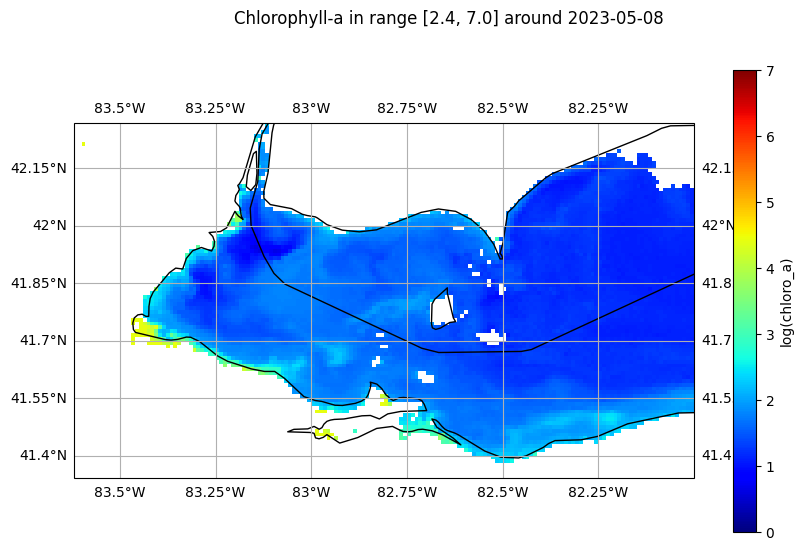

Orig 2023-05-08 00:00:00 Nan: 7624 Non-Nan: 7535
Orig Min: 1.8628538846969604, Max: 363.5261535644531
Orig Min(log): 0.6221096515655518, Max(log): 5.895851135253906

Image 2023-05-08 Nan: 7624 Non-Nan: 7535
Image Min: 0.4891629219055176, Max: 22.92183494567871
Image Min(log): -0.7150596976280212, Max(log): 3.132089853286743
Selected: np.min=(np.float32(0.0), np.float32(3.1320899))


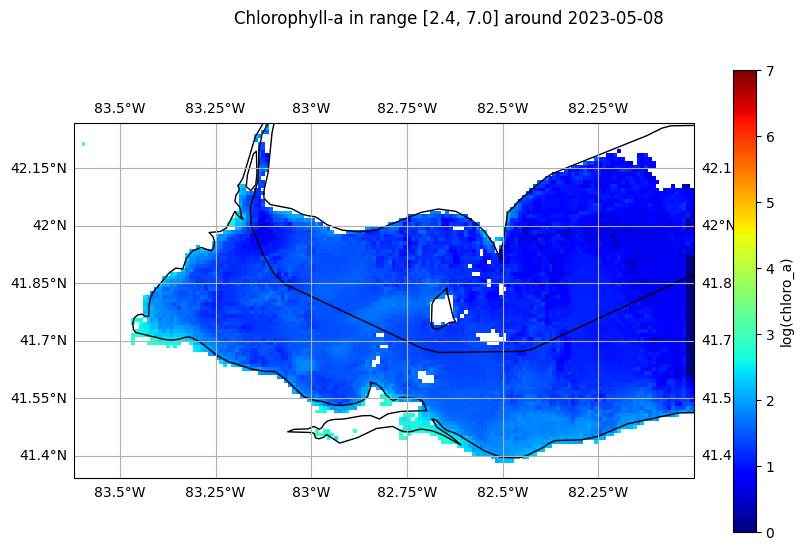

In [51]:
true, pred, error = predict_and_denorm(mymodel, X_test, y_test)
plot_chla(true, sample+5, min_thresh=2.4, max_thresh=7.0)
plot_chla(pred, sample+5, min_thresh=2.4, max_thresh=7.0)

In [52]:
import numpy as np

def evaluate_metrics(y_true, y_pred, mask=None):
    # Assumes y_true and y_pred: (B, H, W, C)
    # mask: (B, H, W) or (B, H, W, 1)

    # Handle mask
    if mask is not None:
        if mask.ndim == 4:
            mask = mask[..., 0]
        mask = np.broadcast_to(mask[..., np.newaxis], y_true.shape)
    else:
        mask = np.isfinite(y_true)  # assume NaNs mask invalid pixels

    # MAE and RMSE per channel
    valid_count = np.sum(mask, axis=(0, 1, 2))  # per channel
    abs_error = np.abs(y_true - y_pred) * mask
    mse = ((y_true - y_pred) ** 2) * mask

    print(f'Masked bits: {np.isnan(mask).sum()}')

    mae_per_channel = np.nansum(abs_error, axis=(0, 1, 2)) / valid_count
    rmse_per_channel = np.sqrt(np.nansum(mse, axis=(0, 1, 2)) / valid_count)

    return mae_per_channel, rmse_per_channel


In [53]:
def normalized_score(mae, rmse, value_range=G_maxChla):
    # value_range is max - min; here it's 2.0 for data scaled to [-1, +1]
    mae_score = 1 - (mae / value_range)
    rmse_score = 1 - (rmse / value_range)
    f1_like_score = 2 * (mae_score * rmse_score) / (mae_score + rmse_score + 1e-8)
    return f1_like_score


In [54]:
mae, rmse = evaluate_metrics(true, pred, None)
print("MAE per channel:", mae)
print("RMSE per channel:", rmse)

f1_like_scores = normalized_score(mae, rmse, value_range=G_maxChla)
summary_score = np.mean(f1_like_scores)
print("F1-like scores per channel:", f1_like_scores)
print("Summary score:", summary_score)

Masked bits: 0
MAE per channel: [1.67844844]
RMSE per channel: [5.89064302]
F1-like scores per channel: [0.99368002]
Summary score: 0.9936800193360823


In [55]:
import numpy as np

def compute_psnr(y_true, y_pred, mask=None, max_val=G_maxChla):
    # y_true, y_pred: shape (H, W, C) or (B, H, W, C)

    if mask is not None:
        mask = mask.astype(np.float32)
        mse = np.nansum(((y_true - y_pred) ** 2) * mask) / (np.sum(mask) + 1e-8)
    else:
        mse = np.nanmean((y_true - y_pred) ** 2)

    psnr = 10 * np.log10((max_val ** 2) / (mse + 1e-8))
    return psnr


In [56]:
psnr = compute_psnr(true, pred, mask=None, max_val=G_maxChla)
print("PSNR:", psnr)

PSNR: 40.15977091577808


In [57]:
import numpy as np
from skimage.metrics import structural_similarity as ssim
#from skimage.measure import compare_ssim as compare_ssim

def masked_ssim_np(y_true, y_pred, mask=None, max_val=G_maxChla):
    """
    Computes SSIM between y_true and y_pred, ignoring NaNs or using mask.
    y_true, y_pred: (H, W, C) or (H, W)
    mask: (H, W) or (H, W, C) boolean array (True = valid pixel)
    """
    if mask is None:
        mask = np.isfinite(y_true) & np.isfinite(y_pred)

    if y_true.ndim == 2:  # single-channel
        y_true = np.expand_dims(y_true, axis=-1)
        y_pred = np.expand_dims(y_pred, axis=-1)
        mask = np.expand_dims(mask, axis=-1)

    ssim_vals = []
    for c in range(y_true.shape[-1]):
        y_t = y_true[..., c]
        y_p = y_pred[..., c]
        m = mask[..., c]

        # Crop to only valid region
        y_t_valid = y_t[m]
        y_p_valid = y_p[m]

        if y_t_valid.size < 9:  # Too few valid pixels
            ssim_vals.append(np.nan)
            continue

        # Reshape to 2D square if possible
        size = int(np.sqrt(y_t_valid.size))
        if size * size < y_t_valid.size:
            size -= 1

        y_t_img = y_t_valid[:size*size].reshape((size, size))
        y_p_img = y_p_valid[:size*size].reshape((size, size))

        ssim_val = ssim(y_t_img, y_p_img, data_range=max_val, channel_axis=-1)
        #ssim_val = compare_ssim(y_t_img, y_p_img, data_range=max_val, multichannel=False)

        ssim_vals.append(ssim_val)

    return np.nanmean(ssim_vals)

ssim_val = masked_ssim_np(true, pred, mask=None, max_val=G_maxChla)
print("SSIM:", ssim_val)

SSIM: 0.9392525641948986


In [58]:
X.shape

(563, 5, 93, 163, 4)

In [59]:
results_list = []
result_dict = {}
debug = False

last_index = X.shape[0] - 5

for sample in range(val_split_index, last_index):
  X_test = X[sample:sample+1,...][:,:,:,:,0:3]
  y_test = y[sample]
  true, pred, error = predict_and_denorm(model, X_test, y_test)

  result_dict = {}
  result_dict['sample'] = sample
  result_dict['prediction_date'] = dates_list[sample+5]
  result_dict['ssim'] = masked_ssim_np(true, pred, mask=None, max_val=G_maxChla)
  result_dict['psnr'] = compute_psnr(true, pred, mask=None, max_val=G_maxChla)
  mae, rmse = evaluate_metrics(true, pred, None)
  f1_like_scores = normalized_score(mae, rmse, value_range=G_maxChla)
  result_dict['summary_f1_score'] = np.mean(f1_like_scores)
  results_list.append(result_dict)
  if debug:
    print(result_dict)

# Convert list of dictionaries to xls
import pandas as pd
df = pd.DataFrame(results_list)
df.to_excel('/content/drive/MyDrive/MIDS-210/CNN-LSTM/results_chla.xlsx', index=False)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
true_frame: (93, 163, 1); valid_mask: (93, 163)
Masked bits: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
true_frame: (93, 163, 1); valid_mask: (93, 163)
Masked bits: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
true_frame: (93, 163, 1); valid_mask: (93, 163)
Masked bits: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
true_frame: (93, 163, 1); valid_mask: (93, 163)
Masked bits: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
true_frame: (93, 163, 1); valid_mask: (93, 163)
Masked bits: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
true_frame: (93, 163, 1); valid_mask: (93, 163)
Masked bits: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
true_frame: (93, 163, 1); valid_mask: (93, 163)
Masked bits: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
true_frame: (93, 163, 1); valid_mask: (93, 163)
Masked bits: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
true_frame: (93, 163, 1); valid_mask: (93, 163)
Masked bits: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
true_frame: (93, 163, 1); valid_mask: (93, 163)
Masked 

In [60]:
import numpy as np
import matplotlib.pyplot as plt

def plot_hist(data, bins):
  plt.hist(data, bins=50, color='skyblue', edgecolor='k')
  plt.title("Data Distribution")
  plt.xlabel("Value")
  plt.ylabel("Frequency")
  plt.grid(True)
  plt.show()


In [61]:
import numpy as np
import matplotlib.pyplot as plt

def plot_hist_side_by_side(true, pred):
  # Example data
  arr1 = (np.nan_to_num(true.flatten()))
  arr2 = (np.nan_to_num(pred.flatten()))

  # Histogram bins (common for both)
  #bins = np.linspace(min(arr1.min(), arr2.min()), max(arr1.max(), arr2.max()), 20)
  # Create custom bins: finer bins below 200, coarser above
  fine_bins = np.arange(0, 500, 20)       # every 10 units
  bins = fine_bins
  #coarse_bins = np.arange(100, 500 + 50, 50)  # every 50 units
  #bins = np.unique(np.concatenate((fine_bins, coarse_bins)))

  # Compute histograms
  hist1, _ = np.histogram(arr1, bins)
  hist2, _ = np.histogram(arr2, bins)

  # Bar width and positions
  bar_width = (bins[1] - bins[0]) * 0.4
  bin_centers = 0.5 * (bins[:-1] + bins[1:])

  # Plot side-by-side bars
  plt.figure(figsize=(10, 6))
  hist1_safe = np.where(hist1 > 0, hist1, 1)
  hist2_safe = np.where(hist2 > 0, hist2, 1)
  plt.bar(bin_centers - bar_width / 2, np.log(hist1_safe), width=bar_width, label='true', alpha=0.5)
  plt.bar(bin_centers + bar_width / 2, np.log(hist2_safe), width=bar_width, label='pred', alpha=0.5)

  plt.xlabel('Value')
  plt.ylabel('log(Number of Pixels)')
  plt.title('Histogram Comparison of True vs Pred values')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()


In [62]:
def plot_pred_chla_for_sample(sample_number, show_sequence=False):

  # Utility function to plot all 5 days and 6th day prediction vs true
  sample = sample_number

  X_test = X[sample:sample+1,...][:,:,:,:,0:3]
  y_test = y[sample]

  for seq_no in range(5):
    xdenorm = get_denormalized_data(X_test[...,0:1], y_test, seq_no)
    if show_sequence:
      plot_chla(xdenorm, sample+seq_no)

  true, pred, error = predict_and_denorm(mymodel, X_test, y_test)
  plot_chla_true_pred(true, pred, sample+5, min_thresh=0, max_thresh=7.0)

  plot_hist(true.flatten(), bins=20)
  plot_hist(pred.flatten(), bins=20)

  plot_hist_side_by_side(true, pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
true_frame: (93, 163, 1); valid_mask: (93, 163)
True 2023-10-29 00:00:00 Nan: 8660 Non-Nan: 6499
True Min: 0.9924147294158474, Max: 81.86544532718445
True Min(log): -0.007614185057941435, Max(log): 4.40507698885171

Pred 2023-10-29 Nan: 8660 Non-Nan: 6499
Pred Min: 1.1461398601531982, Max: 27.649635314941406
Pred Min(log): 0.13639965653419495, Max(log): 3.319612503051758
Selected: np.min=(np.float32(0.0), np.float32(3.3196125))


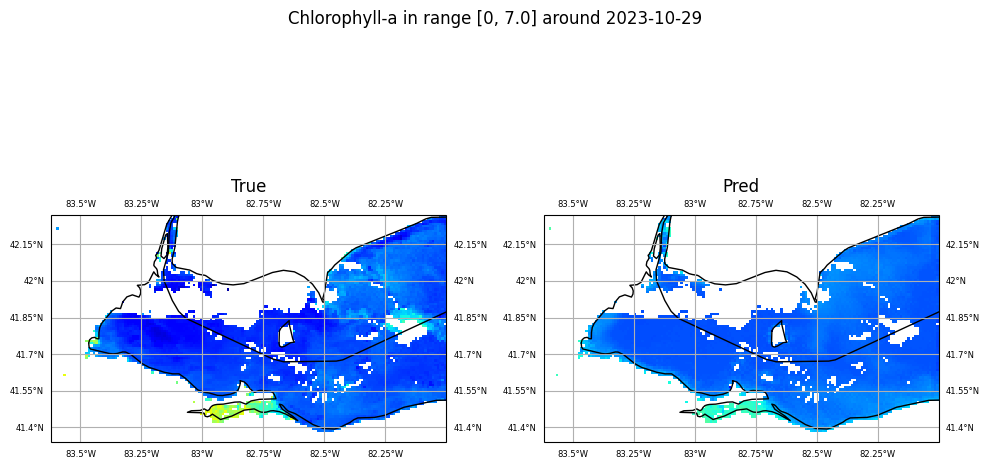

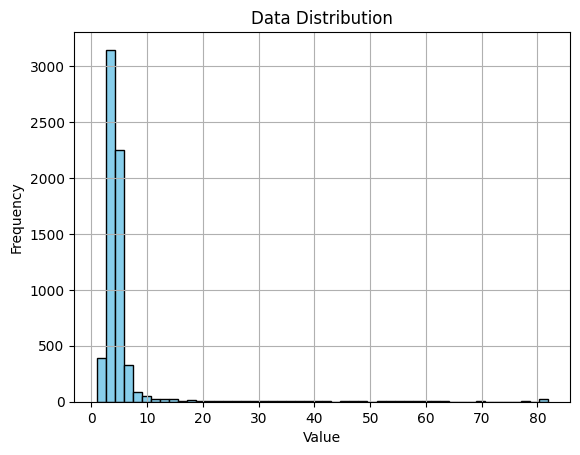

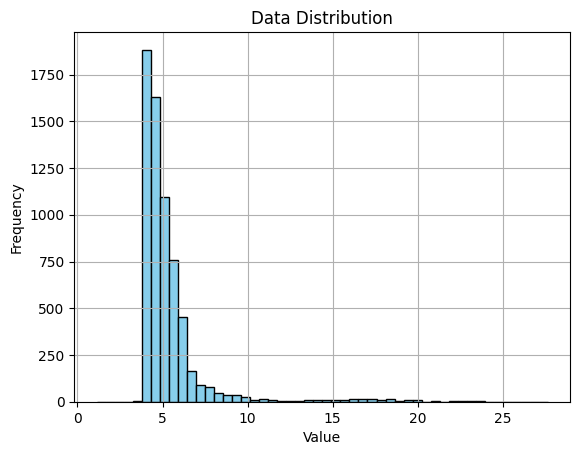

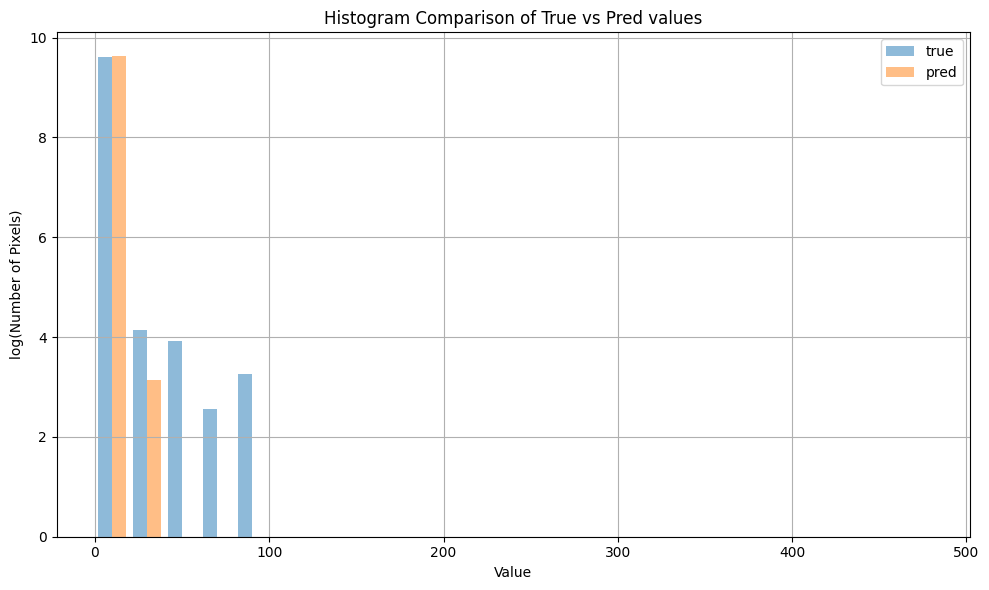

In [63]:
plot_pred_chla_for_sample(451, show_sequence=False)

In [64]:
import pandas as pd

# Assume your DataFrame is called df
df['prediction_date'] = pd.to_datetime(df['prediction_date'])  # Ensure 'date' is datetime

# Create year-month column for grouping
df['year_month'] = df['prediction_date'].dt.to_period('M')

# Get indices of max SSIM per month
best_ssim_indices = df.groupby('year_month')['ssim'].idxmax()

# Use the indices to get corresponding rows
best_ssim_per_month = df.loc[best_ssim_indices].sort_values('prediction_date')

# Optional: drop the 'year_month' helper column
best_ssim_per_month = best_ssim_per_month.drop(columns='year_month')

print(best_ssim_per_month)


     sample prediction_date      ssim       psnr  summary_f1_score
1       451      2023-10-29  0.959578  39.916833          0.993307
3       453      2023-11-10  0.957399  41.047191          0.994051
10      460      2023-12-13  0.943828  38.983811          0.992316
20      470      2024-02-29  0.996627  58.521257          0.998968
24      474      2024-03-15  0.983136  47.421318          0.997031
34      484      2024-04-29  0.987582  49.812807          0.997532
39      489      2024-05-17  0.971706  41.969391          0.995048
43      493      2024-06-01  0.964802  42.331025          0.994834
51      501      2024-07-01  0.950288  38.057646          0.992095
70      520      2024-08-31  0.929534  37.533855          0.990002
78      528      2024-09-24  0.918536  36.461848          0.989529
80      530      2024-10-06  0.966699  41.575812          0.994342
89      539      2024-11-08  0.947270  40.973000          0.993606
92      542      2024-12-23  0.881341  40.462277          0.99

In [65]:
def multiplot_chla_true_pred(best_ssim_per_month, min_thresh=2.5, max_thresh=7.0):

    bestsamples = best_ssim_per_month['sample'].to_list()
    totalsamples = len(bestsamples)
    preddates = best_ssim_per_month['prediction_date'].to_list()

    # Create subplots: 1 row, 2 columns
    fig, axs = plt.subplots(totalsamples, 2, figsize=(10, 6 * totalsamples), subplot_kw={'projection': ccrs.PlateCarree()})

    for i, sample in enumerate(bestsamples):
      X_test = X[sample:sample+1,...][:,:,:,:,0:3]
      y_test = y[sample]
      true, pred, error = predict_and_denorm(mymodel, X_test, y_test)

      epsilon = 1e-10

      # need to use log because of the spread of data
      chlaT = true[0][:,:,0]
      chlaT = np.clip(chlaT, epsilon, None)
      normTrue = np.log(chlaT)

      chlaP = pred[0][:,:,0]
      chlaP = np.clip(chlaP, epsilon, None)
      normPred = np.log(chlaP)

      # Filter the higher value of chla
      mask = (normPred > min_thresh) & (normPred < max_thresh) & np.isfinite(normPred)  # True between thresholds

      axs[i, 0].coastlines(resolution='10m')
      axs[i, 0].add_feature(cfeature.BORDERS)
      axs[i, 0].add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
      axs[i, 0].set_extent([-83.62, -82.0, 41.34, 42.27], crs=ccrs.PlateCarree())

      axs[i, 1].coastlines(resolution='10m')
      axs[i, 1].add_feature(cfeature.BORDERS)
      axs[i, 1].add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
      axs[i, 1].set_extent([-83.62, -82.0, 41.34, 42.27], crs=ccrs.PlateCarree())

      gl = axs[i, 0].gridlines(draw_labels=True)
      gl.xlabel_style = {'size': 6}
      gl.ylabel_style = {'size': 6}

      gl = axs[i, 1].gridlines(draw_labels=True)
      gl.xlabel_style = {'size': 6}
      gl.ylabel_style = {'size': 6}

      axs[i, 0].set_title("True - " + str(preddates[i]), fontsize=10)
      axs[i, 1].set_title("Predicted - " + str(preddates[i]), fontsize=10)


      im1 = axs[i, 0].pcolormesh(lon, lat, normTrue, cmap='jet', shading='auto', vmin=0, vmax=7, transform=ccrs.PlateCarree())
      im2 = axs[i, 1].pcolormesh(lon, lat, normPred, cmap='jet', shading='auto', vmin=0, vmax=7, transform=ccrs.PlateCarree())


    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle

    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
true_frame: (93, 163, 1); valid_mask: (93, 163)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
true_frame: (93, 163, 1); valid_mask: (93, 163)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
true_frame: (93, 163, 1); valid_mask: (93, 163)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
true_frame: (93, 163, 1); valid_mask: (93, 163)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
true_frame: (93, 163, 1); valid_mask: (93, 163)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
true_frame: (93, 163, 1); valid_mask: (93, 163)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
true_frame: (93, 163, 1); valid_mask: (93, 163)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
true_frame: (93, 163, 1); valid_mask: (93, 163)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
true_frame: (93, 163, 1); valid_mask: (93, 163)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
true_frame: (93, 163, 1); valid_mask: (93, 163)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
true_frame: (93, 163, 1); valid_mask: (93, 163)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
true_frame: (93,

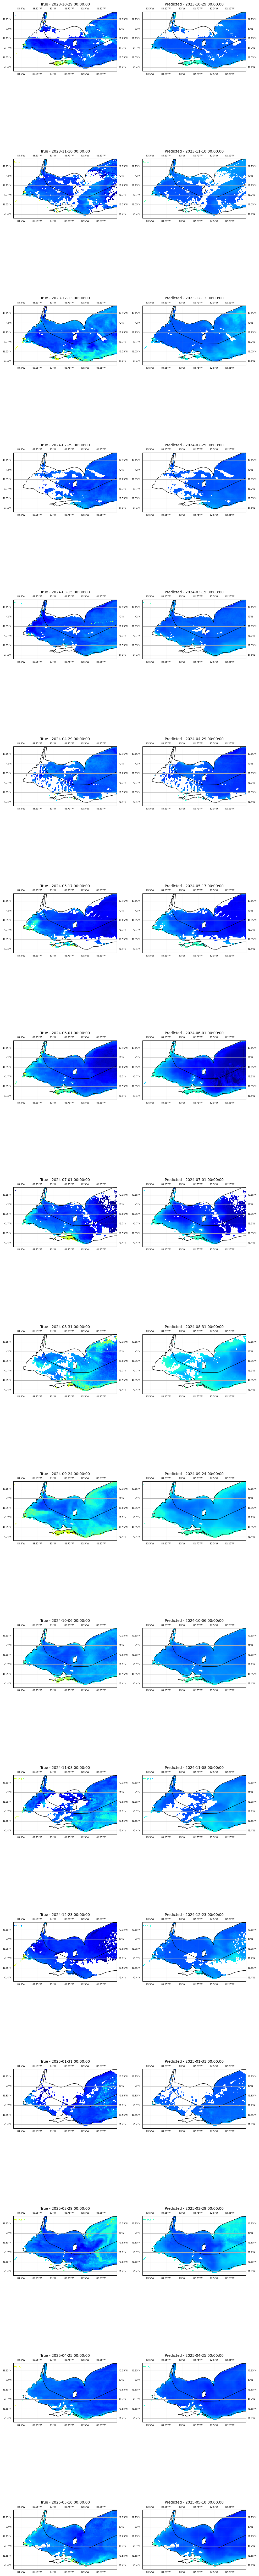

In [66]:
multiplot_chla_true_pred(best_ssim_per_month)